In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import style
import matplotlib.pyplot as plt
import random
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pickle
import copy
style.use("ggplot")

def plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc):
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(train_rolling_loss,label="training")
    plt.plot(dev_rolling_loss,label="dev")
    plt.title("Rolling Loss",loc='center')
    plt.legend(loc=1)
    plt.subplot(222)
    plt.plot(train_rolling_acc,label="training")
    plt.plot(dev_rolling_acc,label="dev")
    plt.title("Rolling Accuracy",loc='center')
    plt.legend(loc=0)
    plt.show()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Pre-process dataset

In [3]:
## reading clean data
raw = pd.read_csv('cleaned-8-Oct-bing.csv')
raw = raw.drop(['oppo_busi','fac_oppo', 'oppo_Industry'],axis=1)
raw

StageName                     RecordType.Name RICE_Supported__c  \
0             0  Custom Education (MSPACE Included)          RIC-BD&I   
1             1                        Parent Grant          RIC-RE&D   
2             1                        Parent Grant          RIC-RE&D   
3             1                        Parent Grant     Not supported   
4             1                        Parent Grant          RIC-RE&D   
...         ...                                 ...               ...   
5403          1                   Research Contract          RIC-BD&I   
5404          0                     Competitive Bid          RIC-BD&I   
5405          1  Custom Education (MSPACE Included)          RIC-BD&I   
5406          1  Custom Education (MSPACE Included)          RIC-BD&I   
5407          1                   Research Contract          RIC-BD&I   

         Lead_Faculty__c      Lead_School__c  Parent_Opportunity__c  \
0     0012e000002ZGfbAAG  0012e000002Zt0mAAC                      0   
1               NotGiven            NotGiven                      0   
2               NotGiven            NotGiven                      0   
3               NotGiven            NotGiven                      0   
4               NotGiven            NotGiven                      0   
...                  ...                 ...                    ...   
5403  0012e000002ZGfbAAG  0012e000002Zt10AAC                      1   
5404            NotGiven            NotGiven                      0   
5405  0012e000002ZmnzAAC  0012e000002Z3p1AAC                      0   
5406  0012e000002ZmnzAAC  0012e000002Z3p1AAC                      0   
5407  0012e000002ZGfbAAG  0012e000002Zt0nAAC                      1   

                                   Industry  \
0                                    Health   
1                     Public Administration   
2                     Public Administration   
3                                    Health   
4                     Public Administration   
...                                     ...   
5403                                 Health   
5404  Construction & Construction Materials   
5405                               Services   
5406                               Services   
5407                                 Health   

                       Industry_Sub_Type__c  \
0               Health Care & Healthy Aging   
1                     Public Administration   
2                     Public Administration   
3               Health Care & Healthy Aging   
4                     Public Administration   
...                                     ...   
5403             Biotechnology (non-Pharma)   
5404  Construction & Construction Materials   
5405                              Education   
5406                              Education   
5407             Biotechnology (non-Pharma)   

                           Business_Type__c  Is_External__c  ParentId  \
0     Multinational / Other Large Corporate               1         0   
1            Government: Australia: Federal               1         1   
2            Government: Australia: Federal               1         1   
3            Government: Australia: Federal               1         0   
4            Government: Australia: Federal               1         1   
...                                     ...             ...       ...   
5403       SME (small to medium enterprise)               1         0   
5404                         Not for profit               1         0   
5405                             University               1         0   
5406                             University               1         0   
5407              Government: International               1         0   

      CreatedYear  CreatedMonth  year_length   RN  f_won_before  
0            2019            11            1    1             0  
1            2018             9           31   10             1  
2            2018             9            2    9             1  
3    

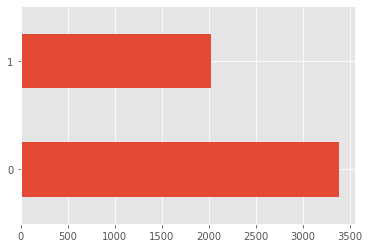

In [4]:
data = raw
raw["StageName"].value_counts(dropna=False).plot(kind="barh")

## 1.1 Resampling imbalanced dataset

Handling unbalanced datasets 2:1 lost to won
- duplicate won opportunities
- adding in weights

### (a) Under-sampling

In [809]:
lost_raw = raw[raw["StageName"]==0]
lost_raw = lost_raw.sample(frac=1).reset_index(drop=True)
lost_under = lost_raw[:2021]

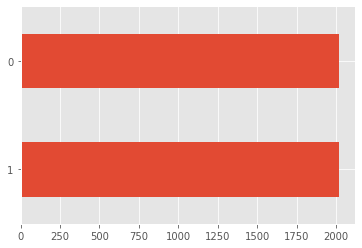

In [811]:
data = pd.concat([raw[raw["StageName"]==1], lost_under], ignore_index=True)
data["StageName"].value_counts(dropna=False).plot(kind="barh")

### (a) Over-sampling

In [731]:
won_raw = raw[raw["StageName"]==1]

In [732]:
data = pd.concat([raw, won_raw], ignore_index=True)

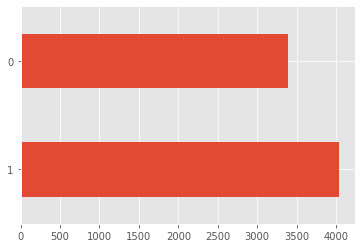

In [733]:
data["StageName"].value_counts(dropna=False).plot(kind="barh")

## 1.2 One hot encoding

In [5]:
## one-hot-encoding

a = pd.get_dummies(data["RecordType.Name"], prefix='RecordType')
b = pd.get_dummies(data["RICE_Supported__c"], prefix='RICE_Supported')
c = pd.get_dummies(data["Lead_Faculty__c"], prefix='Lead_Faculty')
d = pd.get_dummies(data["Lead_School__c"], prefix='Lead_School')
e = pd.get_dummies(data["Industry"], prefix='Industry')
f = pd.get_dummies(data["Industry_Sub_Type__c"], prefix='Industry_Sub')
g = pd.get_dummies(data["Business_Type__c"], prefix='Business')

org = data[["StageName","Parent_Opportunity__c","Is_External__c","ParentId","f_won_before"]]

scale3 = data["CreatedYear"].div(2020)
scale4 = data["CreatedMonth"].div(12)
scale5 = data["year_length"].div(31)
scale6 = data["RN"].div(279)

df = pd.concat([org,scale3,scale4,scale5,scale6,a,b,c,d,e,f,g], axis=1, ignore_index=True)
df

0    1    2    3    4         5         6         7         8    9    \
0       0    0    1    0    0  0.999505  0.916667  0.032258  0.003584    0   
1       1    0    1    1    1  0.999010  0.750000  1.000000  0.035842    0   
2       1    0    1    1    1  0.999010  0.750000  0.064516  0.032258    0   
3       1    0    1    0    1  0.999505  0.166667  0.032258  0.240143    0   
4       1    0    1    1    0  0.998515  0.333333  0.096774  0.003584    0   
...   ...  ...  ...  ...  ...       ...       ...       ...       ...  ...   
5403    1    1    1    0    0  1.000000  0.583333  0.000000  0.003584    0   
5404    0    0    1    0    0  1.000000  0.583333  0.000000  0.003584    0   
5405    1    0    1    0    1  1.000000  0.583333  0.000000  0.996416    0   
5406    1    0    1    0    1  1.000000  0.583333  0.000000  1.000000    0   
5407    1    1    1    0    1  1.000000  0.666667  0.000000  0.010753    0   

      ...  144  145  146  147  148  149  150  151  152  153  
0     ...    0    0    0    0    1    0    0    0    0    0  
1     ...    1    0    0    0    0    0    0    0    0    0  
2     ...    1    0    0    0    0    0    0    0    0    0  
3     ...    1    0    0    0    0    0    0    0    0    0  
4     ...    1    0    0    0    0    0    0    0    0    0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
5403  ...    0    0    0    0    0    0    0    0    1    0  
5404  ...    0    0    0    0    0    1    0    0    0    0  
5405  ...    0    0    0    0    0    0    0    0    0    1  
5406  ...    0    0    0    0    0    0    0    0    0    1  
5407  ...    0    0    1    0    0    0    0    0    0    0  

[5408 rows x 154 columns]

In [6]:
# split xy
dflist = df.values.tolist()
x = torch.Tensor([i[1:] for i in dflist])
y = torch.Tensor([i[0] for i in dflist])

# train/dev split
batch_size = 64
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.33, random_state=42)
train_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_train,y_train)), batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_dev,y_dev)), batch_size=batch_size, shuffle=False)

In [7]:
n_features, n_classes = int(x_train.shape[1]), 1

In [8]:
#raw["StageName"].value_counts(dropna=False)#.plot(kind="barh")
count = raw["StageName"].value_counts()
weights = 1/count.values
weights = weights[y_train.int()]
weights

array([0.00029525, 0.00029525, 0.0004948 , ..., 0.00029525, 0.00029525,
       0.0004948 ])

In [9]:
train_dataset = tuple(zip(x_train,y_train))
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
imbalancedtrainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = sampler)

In [10]:
print(len(y_dev)-y_dev.sum(),y_dev.sum(), y_dev.sum()/len(y_dev))

tensor(1129.) tensor(656.) tensor(0.3675)


In [11]:
print(len(y_train)-y_train.sum(),y_train.sum(), y_train.sum()/len(y_train))

tensor(2258.) tensor(1365.) tensor(0.3768)


In [43]:
y

tensor([0., 1., 1.,  ..., 1., 1., 1.])

# 2. Neural Network Model

In [38]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(n_features,1024)
        #self.linear2 = torch.nn.Linear(1024, 1024)
        #self.linear3 = torch.nn.Linear(1024, 1024)
        #self.linear4 = torch.nn.Linear(1024, 1024)
        #self.linear5 = torch.nn.Linear(1024, 1024)
        #self.linear6 = torch.nn.Linear(1024, 520)
        self.linear7 = torch.nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        #x = F.relu(self.linear3(x))
        #x = F.relu(self.linear4(x))
        #x = F.relu(self.linear5(x))
        #x = F.relu(self.linear6(x))
        x = F.relu(self.linear7(x))
        x = torch.sigmoid(x)
        return x
    
def eval_metrics(outputs,labels):
    #outputs = torch.sigmoid(logit)
    acc = torch.mean(torch.eq(torch.round(outputs), labels).float()).item()
    prec = precision_score(labels.detach().numpy(), torch.round(outputs).detach().numpy())
    rec = recall_score(labels.detach().numpy(), torch.round(outputs).detach().numpy())
    return acc,prec,rec
    

def test_net(test_loader, model, criterion):
    correct = 0
    total = 0
    test_loss = 0.
    test_acc = 0.
    test_prec = 0.
    test_rec = 0.
    scale = len(test_loader)
    
    for features, labels in test_loader:
        features = Variable(features).to(device)
        labels = Variable(labels).to(device)
        
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()
        
        
        
        print(sum(labels * outputs).detach().numpy())
        
        
        labels = labels.cpu()
        outputs = outputs.cpu()
        a,b,c = eval_metrics(outputs,labels)
        test_acc += a
        test_prec += b
        test_rec += c
        
    return test_loss/scale, test_acc/scale, test_prec/scale, test_rec/scale


def train_net(train_loader,dev_loader,lr_rate):
    train_rolling_loss = []
    dev_rolling_loss = []
    train_rolling_acc = []
    dev_rolling_acc = []
    
    test_precision = []
    test_recall = []
    
    criterion = torch.nn.BCELoss() # BCELoss

    for epoch in tqdm(range(int(epochs))):
        train_loss = 0.
        train_acc = 0.
        
        for i, (features, labels) in enumerate(train_loader):
            features = Variable(features).to(device)
            labels = Variable(labels).to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            labels = labels.cpu()
            outputs = outputs.cpu()
            acc,_,__ = eval_metrics(outputs,labels)
            train_acc += acc
        
        train_rolling_acc.append(train_acc/len(train_loader))
        train_rolling_loss.append(train_loss/len(train_loader))

        ## calculating loss on dev set
        
        dev_loss,dev_acc,precision,recall = test_net(dev_loader, model, criterion)
        dev_rolling_loss.append(dev_loss)
        dev_rolling_acc.append(dev_acc)
        
        test_precision.append(precision)
        test_recall.append(recall)
        
    print("Train Loss: ",train_rolling_loss[-1],", Test Loss: ",dev_rolling_loss[-1])
    print("Train Accuracy: ",train_rolling_acc[-1],", Test Accuracy: ",dev_rolling_acc[-1])
    print("Precision: ",test_precision[-1],", Recall: ",test_recall[-1])
    
    plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc)
    
    
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(test_precision,label="training")
    plt.subplot(222)
    plt.plot(test_recall,label="training")
    plt.show()
    
    outfile = open("model.pkl",'wb')
    pickle.dump(model, outfile)
    outfile.close()
    
    return dev_rolling_loss,dev_rolling_acc,test_precision,test_recall

In [17]:
model = Net()
init_state = copy.deepcopy(model.state_dict())

In [18]:
epochs = 10
lr_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
init_state_opt = copy.deepcopy(optimizer.state_dict())

 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

[ 0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      34.83453 34.83453  0.      34.83453  0.      34.83453
  0.       0.       0.      34.83453 34.83453  0.      34.83453  0.
  0.       0.       0.      34.83453 34.83453  0.      34.83453 34.83453
 34.83453  0.       0.       0.       0.      34.83453  0.       0.
 34.83453  0.       0.      34.83453  0.       0.      34.83453  0.
  0.      34.83453 34.83453  0.      34.83453  0.       0.      34.83453
  0.       0.       0.       0.      34.83453 34.83453 34.83453 34.83453]
[ 0.       34.570545 34.570545 34.570545  0.        0.        0.
 34.570545 34.570545 34.570545  0.        0.        0.       34.570545
  0.       34.570545  0.        0.        0.       34.570545  0.
 34.570545  0.       34.570545  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       34.570545
  0.        0.        0.       34.570545 34.570545 34.570545  0.
  0.        0.       34.570545 34

 20%|██        | 2/10 [00:01<00:04,  1.90it/s]

[ 0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      34.91869 34.91869  0.      34.91869  0.      34.91869
  0.       0.       0.      34.91869 34.91869  0.      34.91869  0.
  0.       0.       0.      34.91869 34.91869  0.      34.91869 34.91869
 34.91869  0.       0.       0.       0.      34.91869  0.       0.
 34.91869  0.       0.      34.91869  0.       0.      34.91869  0.
  0.      34.91869 34.91869  0.      34.91869  0.       0.      34.91869
  0.       0.       0.       0.      34.91869 34.91869 34.91869 34.91869]
[ 0.       34.724606 34.724606 34.724606  0.        0.        0.
 34.724606 34.724606 34.724606  0.        0.        0.       34.724606
  0.       34.724606  0.        0.        0.       34.724606  0.
 34.724606  0.       34.724606  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       34.724606
  0.        0.        0.       34.724606 34.724606 34.724606  0.
  0.        0.       34.724606 34

 30%|███       | 3/10 [00:01<00:03,  1.87it/s]

[ 0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      35.88733 35.88733  0.      35.88733  0.      35.88733
  0.       0.       0.      35.88733 35.88733  0.      35.88733  0.
  0.       0.       0.      35.88733 35.88733  0.      35.88733 35.88733
 35.88733  0.       0.       0.       0.      35.88733  0.       0.
 35.88733  0.       0.      35.88733  0.       0.      35.88733  0.
  0.      35.88733 35.88733  0.      35.88733  0.       0.      35.88733
  0.       0.       0.       0.      35.88733 35.88733 35.88733 35.88733]
[ 0.       35.147423 35.147423 35.147423  0.        0.        0.
 35.147423 35.147423 35.147423  0.        0.        0.       35.147423
  0.       35.147423  0.        0.        0.       35.147423  0.
 35.147423  0.       35.147423  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       35.147423
  0.        0.        0.       35.147423 35.147423 35.147423  0.
  0.        0.       35.147423 35

 40%|████      | 4/10 [00:02<00:03,  1.97it/s]

[ 0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      36.16058 36.16058  0.      36.16058  0.      36.16058
  0.       0.       0.      36.16058 36.16058  0.      36.16058  0.
  0.       0.       0.      36.16058 36.16058  0.      36.16058 36.16058
 36.16058  0.       0.       0.       0.      36.16058  0.       0.
 36.16058  0.       0.      36.16058  0.       0.      36.16058  0.
  0.      36.16058 36.16058  0.      36.16058  0.       0.      36.16058
  0.       0.       0.       0.      36.16058 36.16058 36.16058 36.16058]
[ 0.     36.5279 36.5279 36.5279  0.      0.      0.     36.5279 36.5279
 36.5279  0.      0.      0.     36.5279  0.     36.5279  0.      0.
  0.     36.5279  0.     36.5279  0.     36.5279  0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.     36.5279  0.
  0.      0.     36.5279 36.5279 36.5279  0.      0.      0.     36.5279
 36.5279  0.      0.      0.      0.     36.5279  0.     36.5279  0.
 36.5279 36.5

 50%|█████     | 5/10 [00:02<00:02,  2.07it/s]

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       35.828682 35.828682  0.       35.828682
  0.       35.828682  0.        0.        0.       35.828682 35.828682
  0.       35.828682  0.        0.        0.        0.       35.828682
 35.828682  0.       35.828682 35.828682 35.828682  0.        0.
  0.        0.       35.828682  0.        0.       35.828682  0.
  0.       35.828682  0.        0.       35.828682  0.        0.
 35.828682 35.828682  0.       35.828682  0.        0.       35.828682
  0.        0.        0.        0.       35.828682 35.828682 35.828682
 35.828682]
[ 0.      36.02135 36.02135 36.02135  0.       0.       0.      36.02135
 36.02135 36.02135  0.       0.       0.      36.02135  0.      36.02135
  0.       0.       0.      36.02135  0.      36.02135  0.      36.02135
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      36.02135  0.       0.       0.      36.02135 36.02135
 36.02135  0.

 60%|██████    | 6/10 [00:02<00:01,  2.09it/s]

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       35.757015 35.757015  0.       35.757015
  0.       35.757015  0.        0.        0.       35.757015 35.757015
  0.       35.757015  0.        0.        0.        0.       35.757015
 35.757015  0.       35.757015 35.757015 35.757015  0.        0.
  0.        0.       35.757015  0.        0.       35.757015  0.
  0.       35.757015  0.        0.       35.757015  0.        0.
 35.757015 35.757015  0.       35.757015  0.        0.       35.757015
  0.        0.        0.        0.       35.757015 35.757015 35.757015
 35.757015]
[ 0.      35.52037 35.52037 35.52037  0.       0.       0.      35.52037
 35.52037 35.52037  0.       0.       0.      35.52037  0.      35.52037
  0.       0.       0.      35.52037  0.      35.52037  0.      35.52037
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      35.52037  0.       0.       0.      35.52037 35.52037
 35.52037  0.

 70%|███████   | 7/10 [00:03<00:01,  2.06it/s]

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       37.672527 37.672527  0.       37.672527
  0.       37.672527  0.        0.        0.       37.672527 37.672527
  0.       37.672527  0.        0.        0.        0.       37.672527
 37.672527  0.       37.672527 37.672527 37.672527  0.        0.
  0.        0.       37.672527  0.        0.       37.672527  0.
  0.       37.672527  0.        0.       37.672527  0.        0.
 37.672527 37.672527  0.       37.672527  0.        0.       37.672527
  0.        0.        0.        0.       37.672527 37.672527 37.672527
 37.672527]
[ 0.       36.777332 36.777332 36.777332  0.        0.        0.
 36.777332 36.777332 36.777332  0.        0.        0.       36.777332
  0.       36.777332  0.        0.        0.       36.777332  0.
 36.777332  0.       36.777332  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       36.777332
  0.        0.        0.       36.77

 80%|████████  | 8/10 [00:04<00:01,  2.00it/s]

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       37.658726 37.658726  0.       37.658726
  0.       37.658726  0.        0.        0.       37.658726 37.658726
  0.       37.658726  0.        0.        0.        0.       37.658726
 37.658726  0.       37.658726 37.658726 37.658726  0.        0.
  0.        0.       37.658726  0.        0.       37.658726  0.
  0.       37.658726  0.        0.       37.658726  0.        0.
 37.658726 37.658726  0.       37.658726  0.        0.       37.658726
  0.        0.        0.        0.       37.658726 37.658726 37.658726
 37.658726]
[ 0.       37.351177 37.351177 37.351177  0.        0.        0.
 37.351177 37.351177 37.351177  0.        0.        0.       37.351177
  0.       37.351177  0.        0.        0.       37.351177  0.
 37.351177  0.       37.351177  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       37.351177
  0.        0.        0.       37.35

 90%|█████████ | 9/10 [00:04<00:00,  1.90it/s]

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       38.452045 38.452045  0.       38.452045
  0.       38.452045  0.        0.        0.       38.452045 38.452045
  0.       38.452045  0.        0.        0.        0.       38.452045
 38.452045  0.       38.452045 38.452045 38.452045  0.        0.
  0.        0.       38.452045  0.        0.       38.452045  0.
  0.       38.452045  0.        0.       38.452045  0.        0.
 38.452045 38.452045  0.       38.452045  0.        0.       38.452045
  0.        0.        0.        0.       38.452045 38.452045 38.452045
 38.452045]
[ 0.       37.883507 37.883507 37.883507  0.        0.        0.
 37.883507 37.883507 37.883507  0.        0.        0.       37.883507
  0.       37.883507  0.        0.        0.       37.883507  0.
 37.883507  0.       37.883507  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       37.883507
  0.        0.        0.       37.88

100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       38.263954 38.263954  0.       38.263954
  0.       38.263954  0.        0.        0.       38.263954 38.263954
  0.       38.263954  0.        0.        0.        0.       38.263954
 38.263954  0.       38.263954 38.263954 38.263954  0.        0.
  0.        0.       38.263954  0.        0.       38.263954  0.
  0.       38.263954  0.        0.       38.263954  0.        0.
 38.263954 38.263954  0.       38.263954  0.        0.       38.263954
  0.        0.        0.        0.       38.263954 38.263954 38.263954
 38.263954]
[ 0.       37.578114 37.578114 37.578114  0.        0.        0.
 37.578114 37.578114 37.578114  0.        0.        0.       37.578114
  0.       37.578114  0.        0.        0.       37.578114  0.
 37.578114  0.       37.578114  0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       37.578114
  0.        0.        0.       37.57

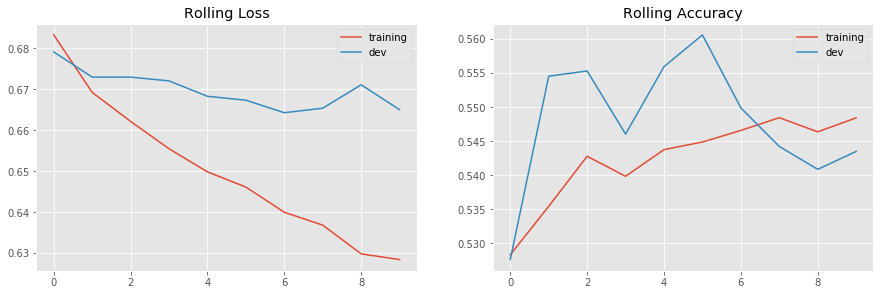

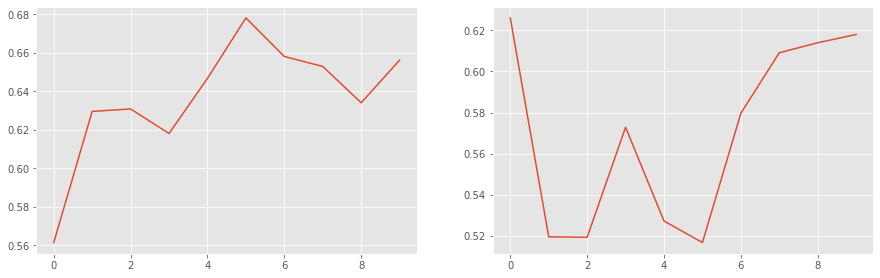

PicklingError: Can't pickle <class '__main__.Net'>: it's not the same object as __main__.Net

In [39]:
#### RUN MODEL
model.load_state_dict(init_state)
optimizer.load_state_dict(init_state_opt)
model.to(device)
results = train_net(train_loader,dev_loader,lr_rate)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Train Loss:  0.6931470716208742 , Test Loss:  0.693147069641522
Train Accuracy:  0.5018907445564604 , Test Accuracy:  0.6324894257954189
Precision:  0.0 , Recall:  0.0


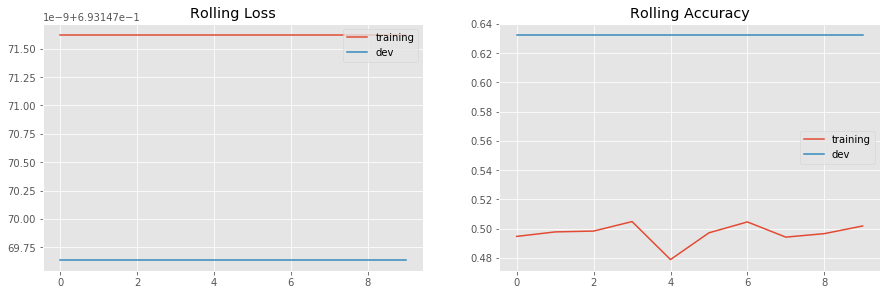

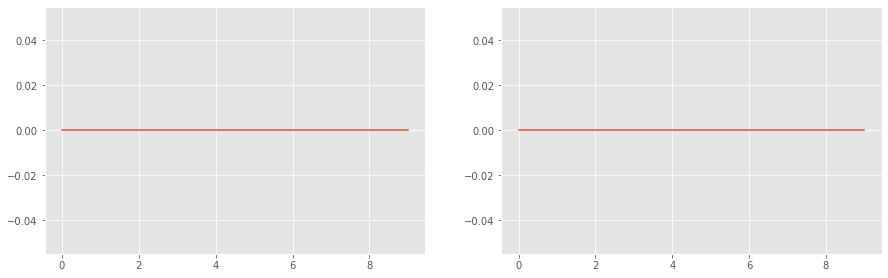

In [48]:
#### RUN MODEL
model.load_state_dict(init_state)
optimizer.load_state_dict(init_state_opt)
model.to(device)
results = train_net(imbalancedtrainloader,dev_loader,lr_rate)

In [31]:
#### Class Distribution Check
accu = 0
total = 0
for features, labels in imbalancedtrainloader:
    features = Variable(features)
    labels = Variable(labels)
    accu += len(labels)-labels.sum()
    total += len(labels)
    
    #print(len(labels),labels.sum())
print("Imb_Train set zeros:\t", accu.item(),total,accu/total)

accu = 0
total = 0
for features, labels in train_loader:
    features = Variable(features)
    labels = Variable(labels)
    accu += len(labels)-labels.sum()
    total += len(labels)
print("Train set zeros:\t", accu.item(),total,accu/total)

zero = 0
total = 0
for features, labels in dev_loader:
    features = Variable(features)
    labels = Variable(labels)
    zero += len(labels)-labels.sum()
    total += len(labels)
    
    outputs = model(features)
    prediction = torch.round(outputs)
    print(prediction.sum())
    
print("Test set zeros:\t\t", zero.item(),total,zero/total)

Imb_Train set zeros:	 1753.0 3623 tensor(0.4839)
Train set zeros:	 2258.0 3623 tensor(0.6232)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward

In [55]:
## model_1 is the best model
loadfile = open("model_1.pkl",'rb')
saved_model = pickle.load(loadfile)
loadfile.close()
test_net(dev_loader, saved_model, torch.nn.BCELoss())

(0.013583977685072031, 0.9649573037790697, 0.9985232543254862, 1.0)

In [ ]:
loadfile = open("model_init.pkl",'rb')
model_init = pickle.load(loadfile)
loadfile.close()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Train Loss:  0.013925376385699998 , Test Loss:  0.013601134293694578
Train Accuracy:  0.9612101765422078 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


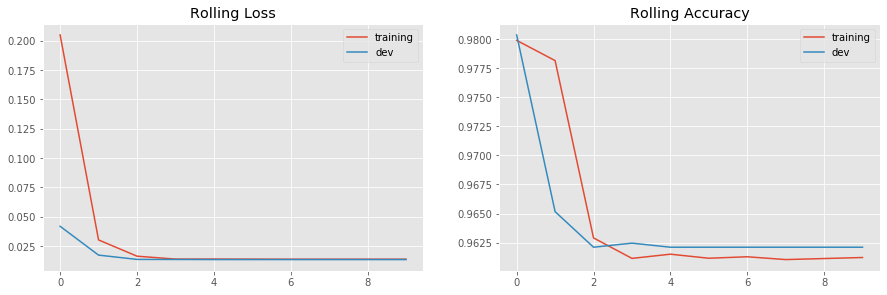

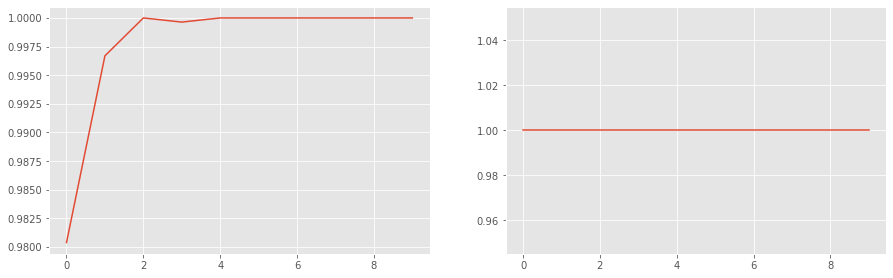

100%|██████████| 10/10 [00:55<00:00,  5.58s/it]


Train Loss:  0.013784325032620066 , Test Loss:  0.014498367940299187
Train Accuracy:  0.961520900974026 , Test Accuracy:  0.9627997819767442
Precision:  0.9992732558139535 , Recall:  1.0


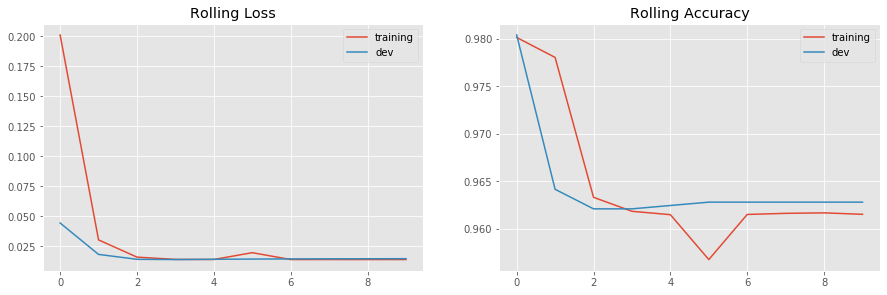

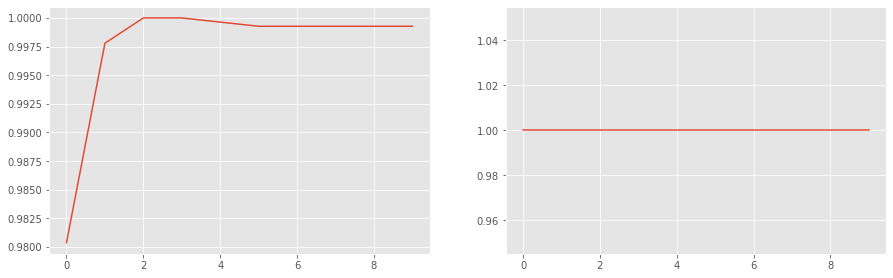

100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Train Loss:  0.013643661441529027 , Test Loss:  0.013601053983546517
Train Accuracy:  0.9619457690746753 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


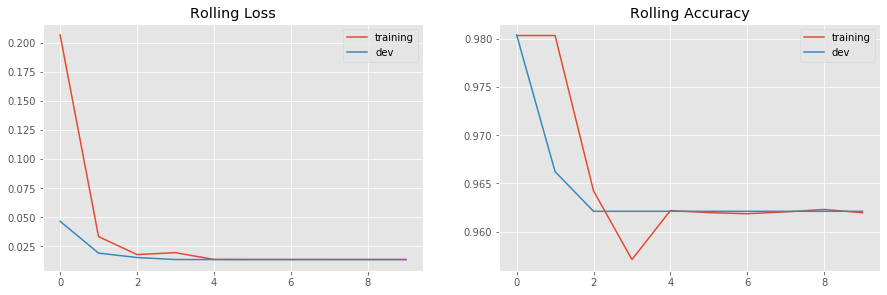

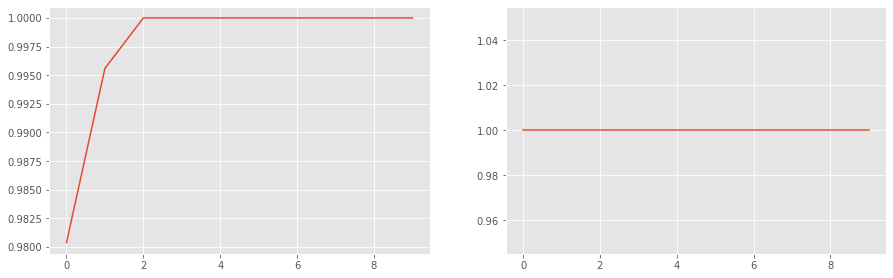

100%|██████████| 10/10 [00:56<00:00,  5.66s/it]


Train Loss:  0.014065557252627793 , Test Loss:  0.014249967757855886
Train Accuracy:  0.9609628652597403 , Test Accuracy:  0.962425054505814
Precision:  0.9996249062265566 , Recall:  1.0


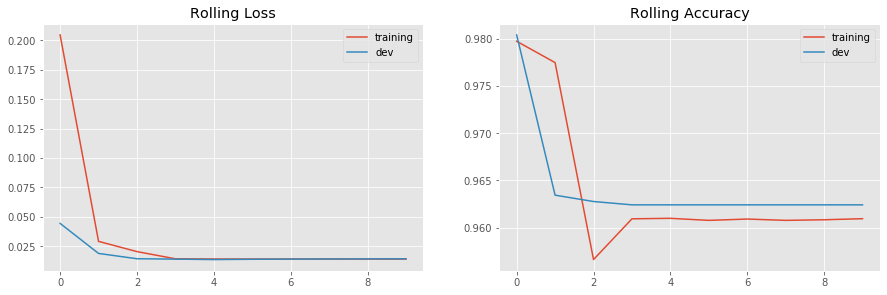

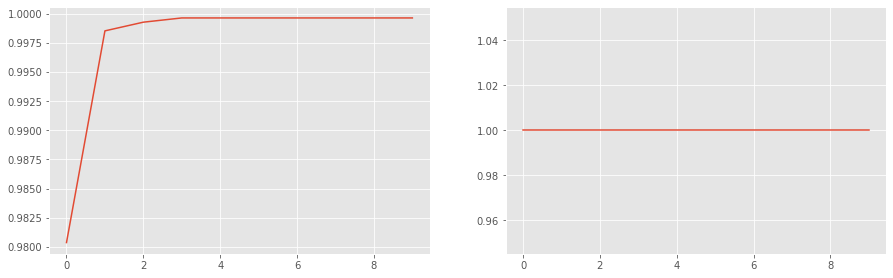

100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


Train Loss:  0.013222004240870553 , Test Loss:  0.014368281549503849
Train Accuracy:  0.9634359780844156 , Test Accuracy:  0.9624477652616279
Precision:  0.9996366279069767 , Recall:  1.0


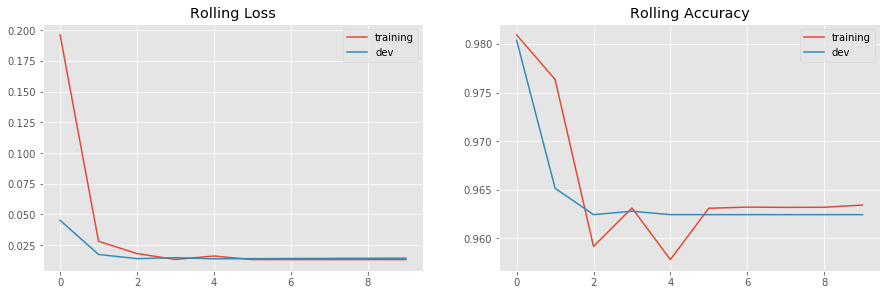

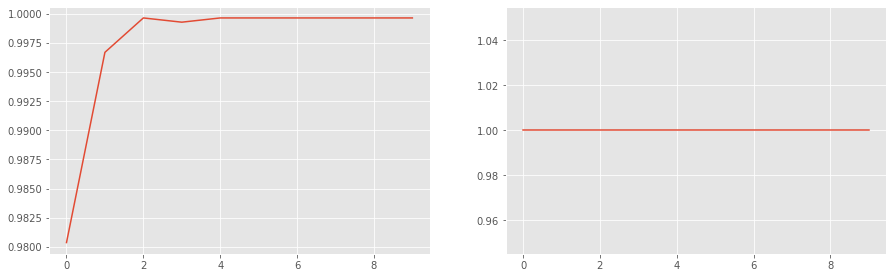

100%|██████████| 10/10 [01:01<00:00,  6.19s/it]


Train Loss:  0.01420654689110242 , Test Loss:  0.013601260678878818
Train Accuracy:  0.9604999492694806 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


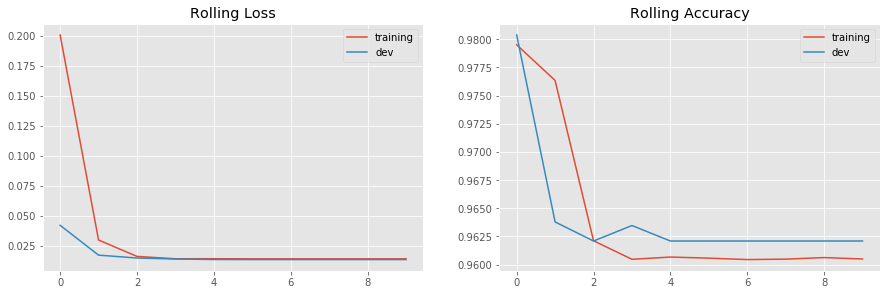

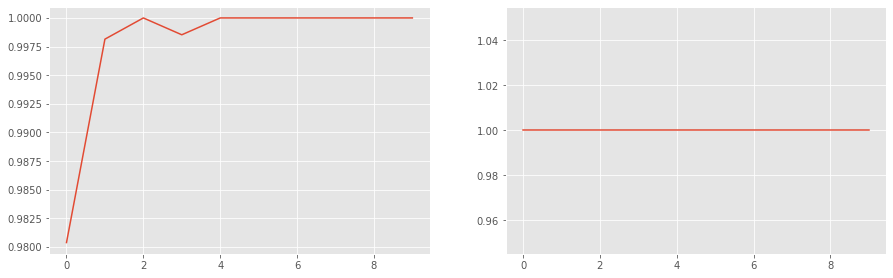

100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


Train Loss:  0.014347694744022834 , Test Loss:  0.01360138194422887
Train Accuracy:  0.9599736201298701 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


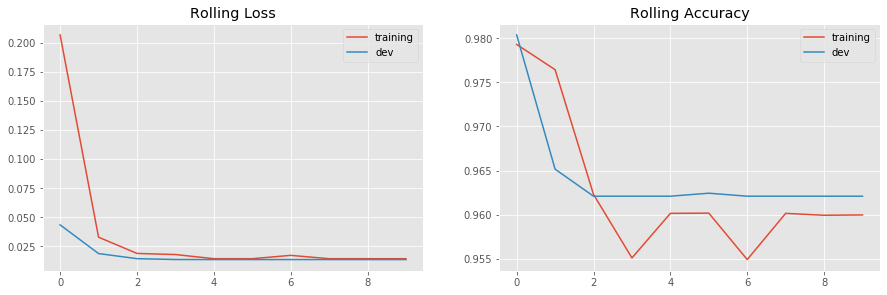

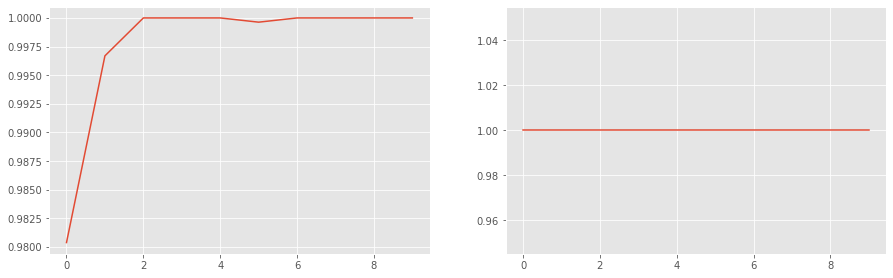

100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


Train Loss:  0.013362392565465094 , Test Loss:  0.013601053896962392
Train Accuracy:  0.9627194094967533 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


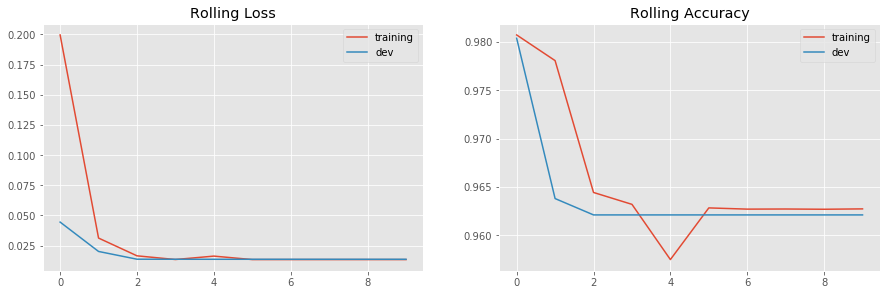

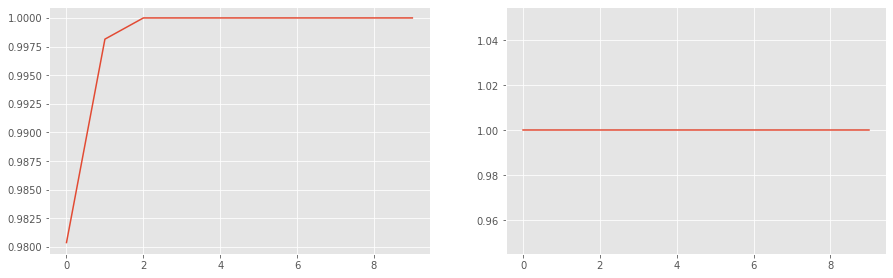

  0%|          | 0/10 [00:00<?, ?it/s]/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
100%|██████████| 10/10 [00:57<00:00,  5.75s/it]


Train Loss:  0.01378476469192368 , Test Loss:  0.014431673950200908
Train Accuracy:  0.961711140422078 , Test Accuracy:  0.962425054505814
Precision:  0.9996249062265566 , Recall:  1.0


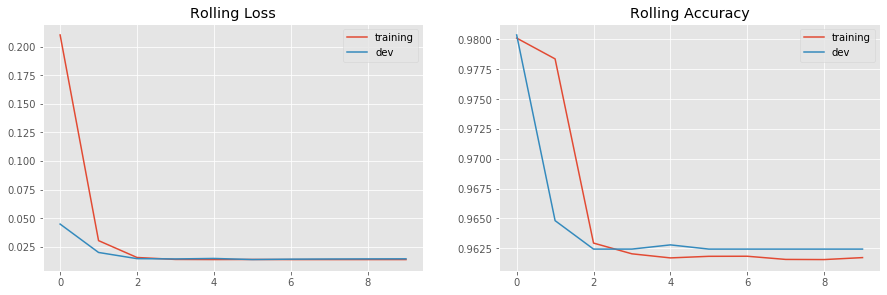

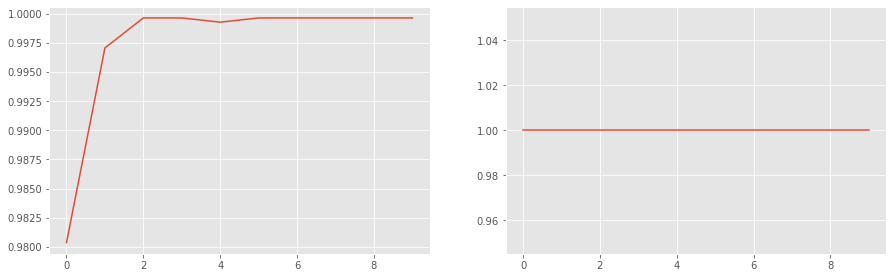

100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


Train Loss:  0.013643774487471012 , Test Loss:  0.01360114166206253
Train Accuracy:  0.9619711343344156 , Test Accuracy:  0.9620957485465116
Precision:  1.0 , Recall:  1.0


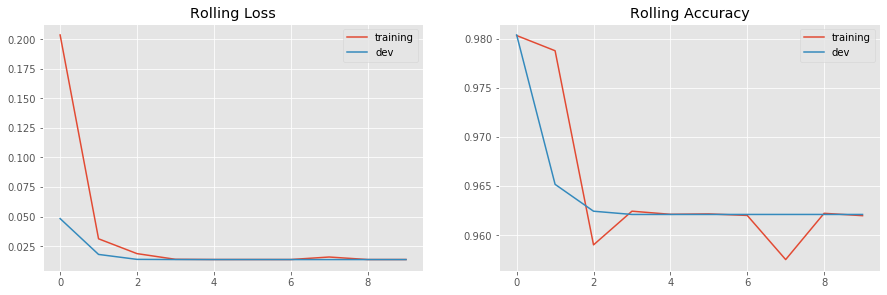

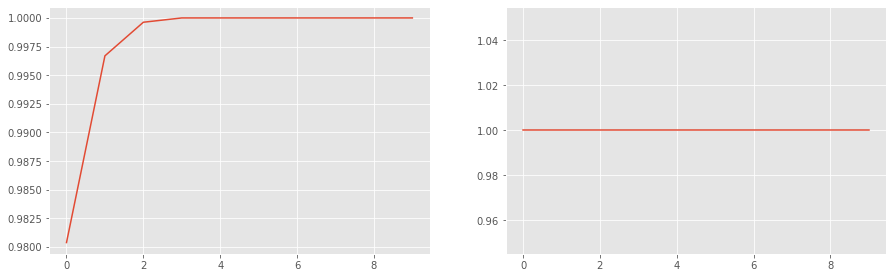

In [78]:
import copy
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10)
batch_size = 64
cv_results = {}

for fold, (train_index, test_index) in enumerate(kfold.split(x, y)):
    x_train_fold = x[train_index]
    x_test_fold = x[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]
    
    train_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_train_fold,y_train_fold)), batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_test_fold,y_test_fold)), batch_size = batch_size, shuffle = False)
    
    model.load_state_dict(init_state)
    optimizer.load_state_dict(init_state_opt)
    model.to(device)
    
    cv_results[fold] = train_net(train_loader,dev_loader,lr_rate)

In [79]:
print("Fold\tBCE Loss\tAccuracy\tPrecision\tRecall")
for k,v in cv_results.items():
    print(k,"\t", round(v[0][-1],5),"\t",round(v[1][-1],5),"\t",round(v[2][-1],5),"\t",round(v[3][-1],5))

Fold	BCE Loss	Accuracy	Precision	Recall
0 	 0.0136 	 0.9621 	 1.0 	 1.0
1 	 0.0145 	 0.9628 	 0.99927 	 1.0
2 	 0.0136 	 0.9621 	 1.0 	 1.0
3 	 0.01425 	 0.96243 	 0.99962 	 1.0
4 	 0.01437 	 0.96245 	 0.99964 	 1.0
5 	 0.0136 	 0.9621 	 1.0 	 1.0
6 	 0.0136 	 0.9621 	 1.0 	 1.0
7 	 0.0136 	 0.9621 	 1.0 	 1.0
8 	 0.01443 	 0.96243 	 0.99962 	 1.0
9 	 0.0136 	 0.9621 	 1.0 	 1.0


In [58]:
print("Fold\tBCE Loss\tAccuracy\tPrecision\tRecall")
for k,v in cv_results.items():
    print(k,"\t", round(v[0][-1],5),"\t",round(v[1][-1],5),"\t",round(v[2][-1],5),"\t",round(v[3][-1],5))

Fold	BCE Loss	Accuracy	Precision	Recall
0 	 0.0131 	 0.96359 	 1.0 	 1.0
1 	 0.0131 	 0.96359 	 1.0 	 1.0
2 	 0.01448 	 0.96394 	 0.99963 	 1.0
3 	 0.01352 	 0.96395 	 0.99964 	 1.0
4 	 0.01491 	 0.96392 	 0.99962 	 1.0


In [165]:
print("Fold\tBCE Loss\tAccuracy\tPrecision\tRecall")
for k,v in cv_results.items():
    print(k,"\t", round(v[0][-1],5),"\t",round(v[1][-1],5),"\t",round(v[2][-1],5),"\t",round(v[3][-1],5))

Fold	BCE Loss	Accuracy	Precision	Recall
0 	 0.01787 	 0.9649 	 0.99943 	 1.0
1 	 0.01306 	 0.9649 	 0.99943 	 1.0
2 	 0.01306 	 0.9649 	 0.99943 	 1.0
3 	 0.02093 	 0.9649 	 0.99943 	 1.0
4 	 0.01499 	 0.96541 	 0.99886 	 1.0


Fold	BCE Loss	Accuracy	Precision	Recall
0 	 0.01787 	 0.9649 	 0.99943 	 1.0
1 	 0.01306 	 0.9649 	 0.99943 	 1.0
2 	 0.01306 	 0.9649 	 0.99943 	 1.0
3 	 0.02093 	 0.9649 	 0.99943 	 1.0
4 	 0.01499 	 0.96541 	 0.99886 	 1.0

# 3. Predicting

In [109]:
predict_data = pd.read_csv('predict.csv')
predict_data = predict_data.drop(columns=['RecordType.Name.1'])
predict_data.head()

StageName RecordType.Name RICE_Supported__c  Actual_Close_Date__c  \
0    Closed    Parent Grant          NotGiven                     0   
1    Closed    Parent Grant          NotGiven                     0   
2    Closed    Parent Grant          NotGiven                     0   
3    Closed    Parent Grant          NotGiven                     0   
4    Closed    Parent Grant          NotGiven                     0   

  Lead_Faculty__c Lead_School__c  Parent_Opportunity__c  \
0        NotGiven       NotGiven                      0   
1        NotGiven       NotGiven                      0   
2        NotGiven       NotGiven                      0   
3        NotGiven       NotGiven                      0   
4        NotGiven       NotGiven                      0   

                Industry Industry_Sub_Type__c  \
0  Public Administration                  NaN   
1  Public Administration                  NaN   
2  Public Administration                  NaN   
3     Energy & Utilities                  NaN   
4                 Health      Pharmaceuticals   

                        Business_Type__c  Is_External__c  ParentId  CloseYear  \
0         Government: Australia: Federal               1         1       2049   
1         Government: Australia: Federal               1         0       2049   
2         Government: Australia: Federal               1         0       2049   
3         Government: Australia: Federal               1         1       2049   
4  Multinational / Other Large Corporate               1         0       2049   

   CloseMonth  CreatedYear  CreatedMonth  time_length  
0          12         2016             7           33  
1          12         2016             7           33  
2          12         2017             4           32  
3          12         2017             6           32  
4          12         2017            11           32

In [113]:
whole_data = pd.concat([data,predict_data], axis=0, ignore_index=True)
whole_data

StageName                     RecordType.Name RICE_Supported__c  \
0                    0  Custom Education (MSPACE Included)          RIC-BD&I   
1                    1                        Parent Grant          RIC-RE&D   
2                    1                        Parent Grant          RIC-RE&D   
3                    1                        Parent Grant     Not supported   
4                    1                        Parent Grant          RIC-RE&D   
...                ...                                 ...               ...   
6835  Awaiting Results                              Grants          RIC-BD&I   
6836  Awaiting Results                              Grants          RIC-BD&I   
6837  Awaiting Results                              Grants          RIC-BD&I   
6838       Identifying                   Research Contract          RIC-BD&I   
6839       Identifying                              Grants          RIC-BD&I   

      Actual_Close_Date__c     Lead_Faculty__c      Lead_School__c  \
0                        1  0012e000002ZGfbAAG  0012e000002Zt0mAAC   
1                        0            NotGiven            NotGiven   
2                        1            NotGiven            NotGiven   
3                        1            NotGiven            NotGiven   
4                        1            NotGiven            NotGiven   
...                    ...                 ...                 ...   
6835                     0  0012e000002ZmOZAA0  0012e000002ZLgBAAW   
6836                     0  0012e000002ZLg7AAG  0012e000002Z3pPAAS   
6837                     0  0012e000002Zt0MAAS            NotGiven   
6838                     0  0012e000002ZLg7AAG  0012e000002Zt0cAAC   
6839                     0  0012e000002ZLg7AAG  0012e000002Zt0bAAC   

      Parent_Opportunity__c               Industry  \
0                         0                 Health   
1                         0  Public Administration   
2                         0  Public Administration   
3                         0                 Health   
4                         0  Public Administration   
...                     ...                    ...   
6835                      1  Public Administration   
6836                      1  Public Administration   
6837                      1  Public Administration   
6838                      0               Services   
6839                      1  Public Administration   

             Industry_Sub_Type__c                       Business_Type__c  \
0     Health Care & Healthy Aging  Multinational / Other Large Corporate   
1           Public Administration         Government: Australia: Federal   
2           Public Administration         Government: Australia: Federal   
3     Health Care & Healthy Aging         Government: Australia: Federal   
4           Public Administration         Government: Australia: Federal   
...                           ...                                    ...   
6835                          NaN         Government: Australia: Federal   
6836                          NaN         Government: Australia: Federal   
6837                          NaN         Government: Australia: Federal   
6838      Business & Professional       SME (small to medium enterprise)   
6839                          NaN         Government: Australia: Federal   

      Is_External__c  ParentId  CloseYear  CloseMonth  CreatedYear  \
0                  1         0       2020           8         2019   
1                  1         1       2049          12         2018   
2                  1         1       2020           6         2018   
3                  1         0       2020           6         2019   
4                  1         1       2020           6         2017   
...              ...       ...        ...         ...          ...   
6835               1         1       2020          10         2020   
6836               1         1       2020           9         2020   
6837               

In [114]:
## one-hot-encoding
a = pd.get_dummies(whole_data["RecordType.Name"], prefix='RecordType')
b = pd.get_dummies(whole_data["RICE_Supported__c"], prefix='RICE_Supported')
c = pd.get_dummies(whole_data["Lead_Faculty__c"], prefix='Lead_Faculty')
d = pd.get_dummies(whole_data["Lead_School__c"], prefix='Lead_School')
e = pd.get_dummies(whole_data["Industry"], prefix='Industry')
f = pd.get_dummies(whole_data["Industry_Sub_Type__c"], prefix='Industry_Sub')
g = pd.get_dummies(whole_data["Business_Type__c"], prefix='Business')

org = whole_data[["StageName","Actual_Close_Date__c","Parent_Opportunity__c","Is_External__c","ParentId"]]

scale1 = whole_data["CloseYear"].div(2050)
scale2 = whole_data["CloseMonth"].div(12)
scale3 = whole_data["CreatedYear"].div(2020)
scale4 = whole_data["CreatedMonth"].div(12)
scale5 = whole_data["time_length"].div(31)

whole_df = pd.concat([org,scale1,scale2,scale3,scale4,scale5,a,b,c,d,e,f,g], axis=1, ignore_index=True)
whole_df

0    1    2    3    4         5         6         7    \
0                    0    1    0    1    0  0.985366  0.666667  0.999505   
1                    1    0    0    1    1  0.999512  1.000000  0.999010   
2                    1    1    0    1    1  0.985366  0.500000  0.999010   
3                    1    1    0    1    0  0.985366  0.500000  0.999505   
4                    1    1    0    1    1  0.985366  0.500000  0.998515   
...                ...  ...  ...  ...  ...       ...       ...       ...   
6835  Awaiting Results    0    1    1    1  0.985366  0.833333  1.000000   
6836  Awaiting Results    0    1    1    1  0.985366  0.750000  1.000000   
6837  Awaiting Results    0    1    1    1  0.985366  0.750000  1.000000   
6838       Identifying    0    0    1    0  0.985366  1.000000  1.000000   
6839       Identifying    0    1    1    1  0.985366  0.916667  1.000000   

           8         9    ...  146  147  148  149  150  151  152  153  154  \
0     0.916667  0.032258  ...    0    0    0    0    1    0    0    0    0   
1     0.750000  1.000000  ...    1    0    0    0    0    0    0    0    0   
2     0.750000  0.064516  ...    1    0    0    0    0    0    0    0    0   
3     0.166667  0.032258  ...    1    0    0    0    0    0    0    0    0   
4     0.333333  0.096774  ...    1    0    0    0    0    0    0    0    0   
...        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6835  0.666667  0.000000  ...    1    0    0    0    0    0    0    0    0   
6836  0.666667  0.000000  ...    1    0    0    0    0    0    0    0    0   
6837  0.666667  0.000000  ...    1    0    0    0    0    0    0    0    0   
6838  0.666667  0.000000  ...    0    0    0    0    0    0    0    0    1   
6839  0.666667  0.000000  ...    1    0    0    0    0    0    0    0    0   

      155  
0       0  
1       0  
2       0  
3       0  
4       0  
...   ...  
6835    0  
6836    0  
6837    0  
6838    0  
6839    0  

[6840 rows x 156 columns]

In [88]:
whole_x = torch.Tensor([i[1:] for i in df.values.tolist()])

torch.Size([1432, 128])

In [87]:
prediction = model(Variable(predict_x))

RuntimeError: size mismatch, m1: [1432 x 128], m2: [153 x 1024] at /tmp/pip-req-build-9oilk29k/aten/src/TH/generic/THTensorMath.cpp:197

In [ ]:
def eval_metrics(ouputs,labels):
    accuracy = torch.mean(torch.eq(outputs, labels).float()).item()

    target_true = torch.sum(labels == 1).float()
    predicted_true = torch.sum(outputs).float()
    correct_true = torch.sum(labels * outputs).float()

    recall = correct_true / target_true
    precision = correct_true / (predicted_true+0.00000000001)
    return accuracy,precision.cpu().item(),recall.cpu().item()

0.12512868818203565


/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


(0.9552856683731079, 0.9299499642601858, 0.9531135531135531)
(0.7310924530029297, 0.6517241379310345, 0.5762195121951219)


/Users/huangraelene/opt/anaconda3/envs/tnsfl/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


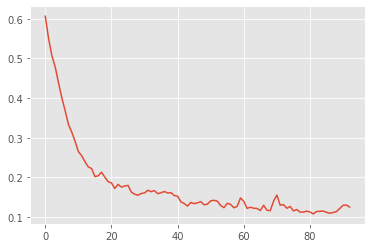

In [110]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(1024,1024,1024,1024,1024,1024,1024,1024),batch_size=84)
clf.fit(x_train, y_train)
print(clf.loss_)
train_pred = clf.predict(x_train)
print(eval_metrics(torch.tensor(train_pred),torch.tensor(y_train)))
dev_pred = clf.predict(x_dev)
print(eval_metrics(torch.tensor(dev_pred),torch.tensor(y_dev)))
plt.plot(clf.loss_curve_)

In [109]:
clf.score(x_train, y_train)

0.9447971294507315

In [108]:
clf.score(x_train, y_train,sample_weight=weights)

0.9427677462776786

In [117]:
clf.intercepts_

[array([-0.02713502,  0.02265918,  0.02704546, ..., -0.0842095 ,
         0.00613946, -0.00106793]),
 array([-0.02323521, -0.04511786, -0.03761998, ..., -0.04326935,
        -0.01843684, -0.01942426]),
 array([-0.03441355,  0.01003686, -0.07523736, ...,  0.04130011,
        -0.01339252, -0.02202803]),
 array([-0.00229412,  0.01136817, -0.01878736, ..., -0.00165924,
        -0.05878932, -0.03687879]),
 array([-0.00535354, -0.02217291, -0.07870441, ..., -0.03390932,
        -0.02190101, -0.02727766]),
 array([ 0.00047958, -0.0028839 , -0.04296525, ..., -0.02508291,
        -0.04509315, -0.06042972]),
 array([-0.04329286, -0.01492557, -0.00882015, ..., -0.02140576,
        -0.03988414, -0.02382272]),
 array([ 0.00368607, -0.00312676,  0.0001407 , ..., -0.00823242,
        -0.05363228,  0.01076476]),
 array([-0.06205535])]